In [ ]:
library(dplyr)
library(tsibble)
library(fable)
library(ggplot2)
library(tidyr)
library(purrr)
library(feasts)
install.packages("GGally")
library(GGally)
library(patchwork)
options(repr.plot.width = 20, repr.plot.height = 7, repr.plot.res = 100)

# Source Helper Functions
source("../Baseline/baseline_helpers.R")
source("../Data_Inspection/data_cleaning_helpers.R")

# Clean validation data
validation <- get_validation_data()

dates <- get_dates()

train <- get_train_data()


In [ ]:
train |>
  filter(product == "FOODS_3_001") |>
  model(
    STL(
      sales ~ trend(window = 365) +
        season(period = 7) +
        season(period = 365),
      robust = TRUE
    )
  ) |>
  components() |>
  autoplot()
train |>
  filter(product == "FOODS_3_002") |>
  model(
    STL(
      sales ~ trend(window = 365) +
        season(period = 7) +
        season(period = 365),
      robust = TRUE
    )
  ) |>
  components() |>
  autoplot()
train |>
  filter(product == "FOODS_3_003") |>
  model(
    STL(
      sales ~ trend(window = 365) +
        season(period = 7) +
        season(period = 365),
      robust = TRUE
    )
  ) |>
  components() |>
  autoplot()
train |>
  filter(product == "FOODS_3_004") |>
  model(
    STL(
      sales ~ trend(window = 365) +
        season(period = 7) +
        season(period = 365),
      robust = TRUE
    )
  ) |>
  components() |>
  autoplot()
# train |> filter(product == "FOODS_3_001") |> features(sales, feat_acf)
# train |>  features(sales, unitroot_ndiffs)
# train |>  features(sales, feat_acf)


In [ ]:
feat_stl <- train |>
  group_by(product) |>
  features(
    sales,
    feat_stl,
    .model = STL(
      sales ~ trend(window = 365) +
        season(period = 7) +
        season(period = 365),
      robust = TRUE
    )
  )


In [ ]:
intermittency_features <- function(y) {
  y <- as.numeric(y)
  y[is.na(y)] <- 0

  nz_idx <- which(y > 0)
  p_zero <- mean(y == 0)

  # Average inter-demand interval (ADI)
  adi <- if (length(nz_idx) <= 1) Inf else mean(diff(nz_idx))

  # Non-zero statistics
  y_nz <- y[y > 0]
  mean_nz <- if (length(y_nz) == 0) 0 else mean(y_nz)
  var_nz <- if (length(y_nz) <= 1) 0 else var(y_nz)

  cv2 <- if (mean_nz <= 0) Inf else var_nz / (mean_nz^2)

  tibble(
    p_zero = p_zero,
    adi = adi,
    mean_nz = mean_nz,
    cv2 = cv2
  )
}

feat_int <- train |>
  as_tibble() |>
  group_by(product) |>
  summarise(intermittency_features(sales), .groups = "drop")
head(feat_int)


product,p_zero,adi,mean_nz,cv2
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
FOODS_3_001,0.7741767,4.431555,1.451389,0.3359118
FOODS_3_002,0.3569097,1.477966,2.362098,0.3810892
FOODS_3_003,0.6745690,3.033333,1.496689,0.3206685
FOODS_3_004,0.8800755,8.341270,1.275591,0.1919550
FOODS_3_005,0.5279665,2.117517,1.615725,0.3531852
FOODS_3_006,0.4919455,1.963325,1.700000,0.2944984


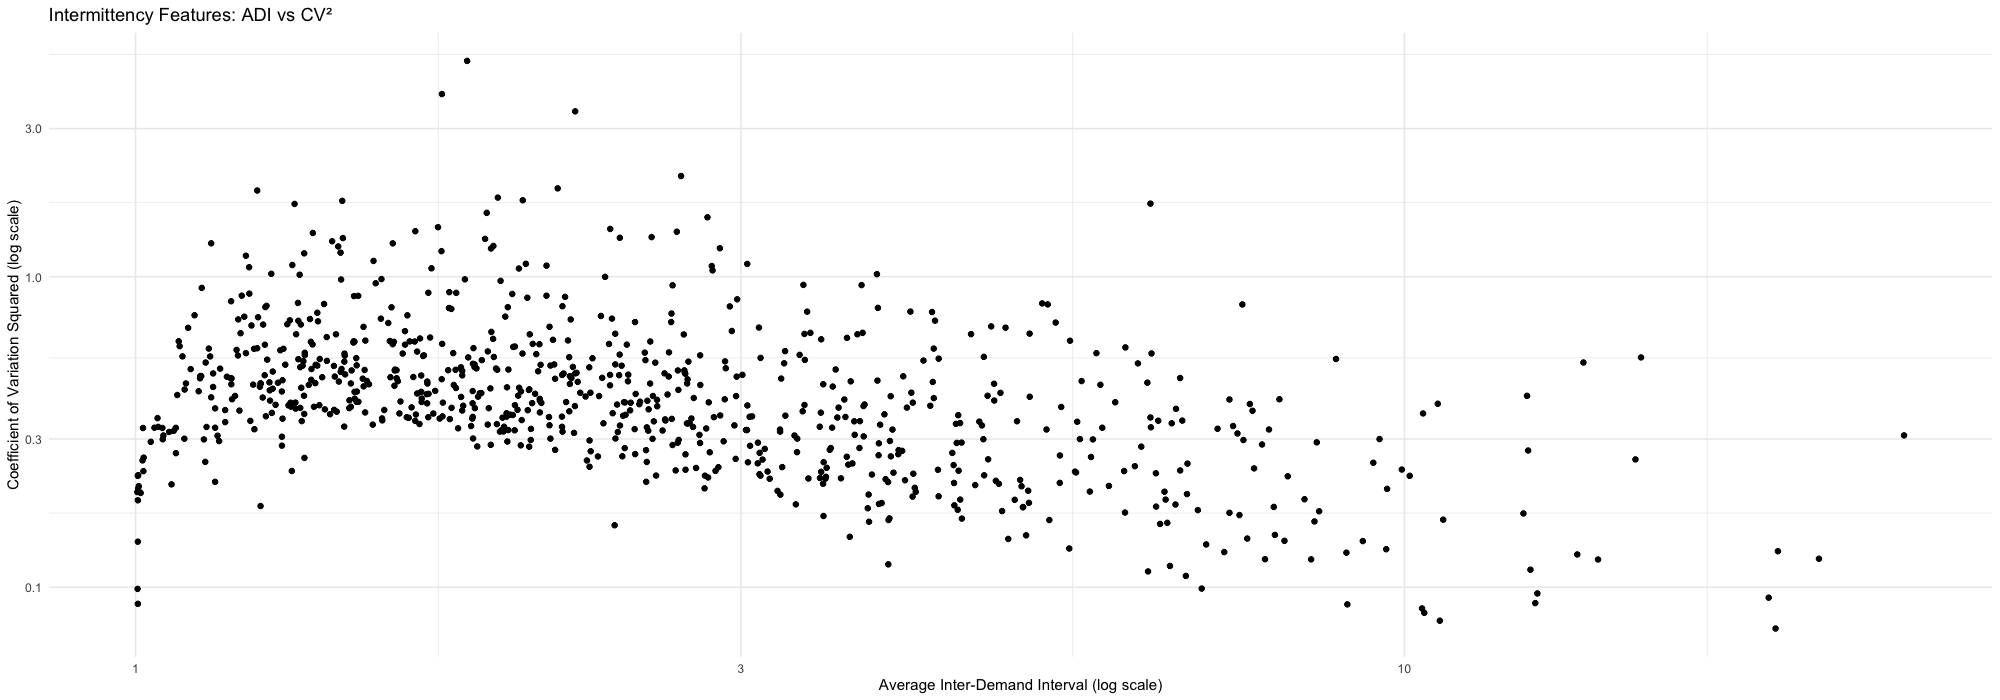

In [ ]:
ggplot(feat_int, aes(x = adi, y = cv2)) +
  geom_point() +
  scale_x_log10() +
  scale_y_log10() +
  labs(
    title = "Intermittency Features: ADI vs CV²",
    x = "Average Inter-Demand Interval (log scale)",
    y = "Coefficient of Variation Squared (log scale)"
  ) +
  theme_minimal()


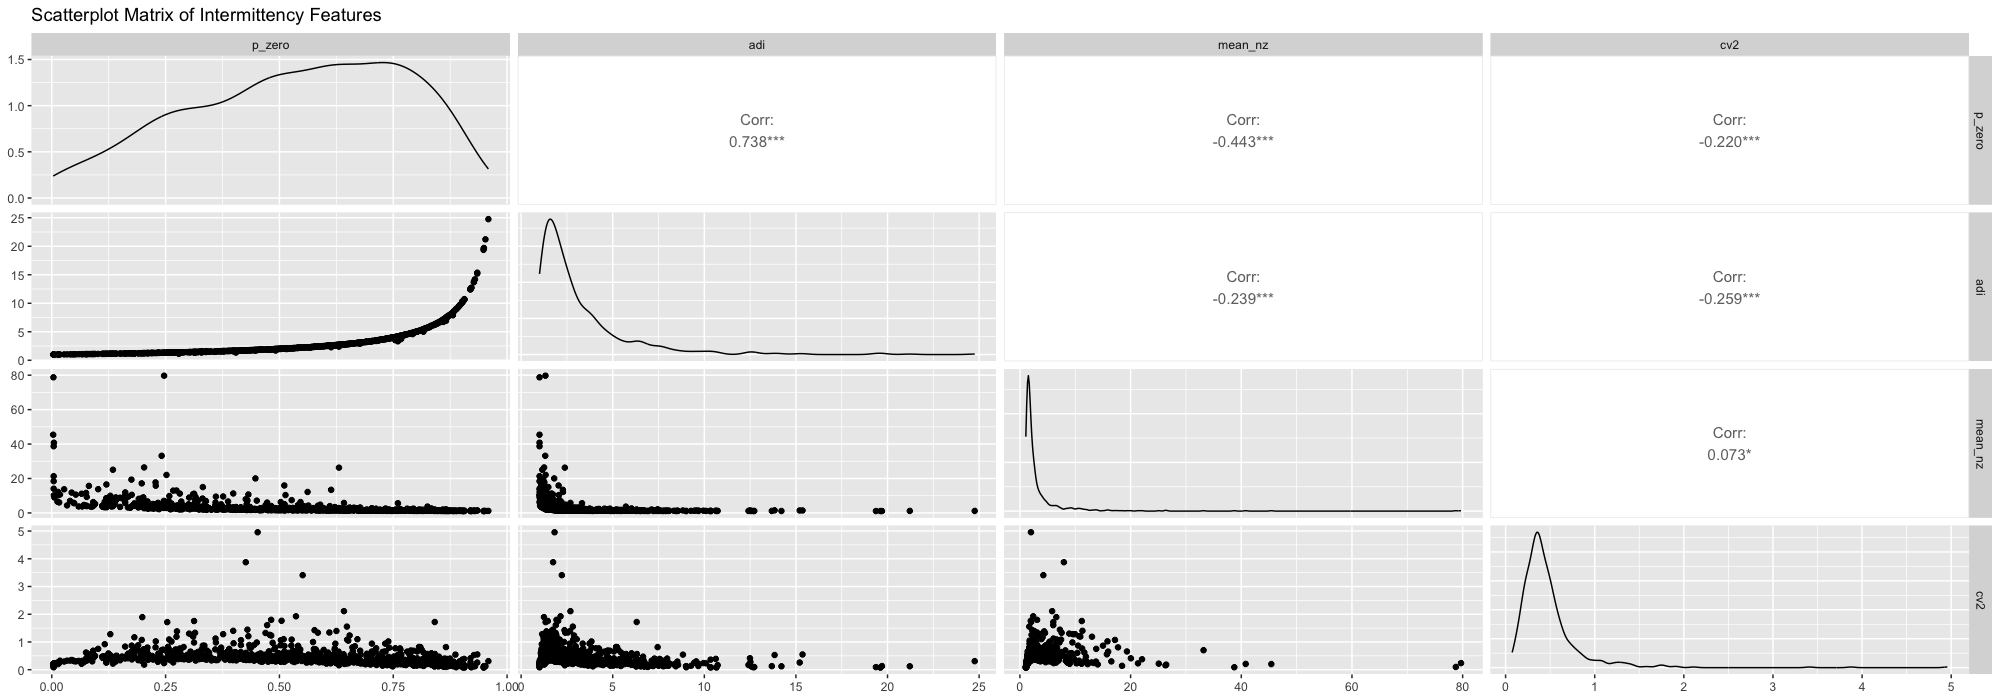

In [24]:
ggpairs(
  feat_int,
  columns = c("p_zero", "adi", "mean_nz", "cv2"),
  title = "Scatterplot Matrix of Intermittency Features"
)


In [ ]:
n_distinct(train$product) # expected rows in feat_int
nrow(feat_int) # should match
any(is.infinite(feat_int$adi))
any(is.infinite(feat_int$cv2))


[1] 823

[1] 1246617

[1] TRUE

[1] TRUE

In [12]:
feat_int$adi


[1] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
   [19] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
   [37] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
   [55] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
   [73] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
   [91] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [109] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [127] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [145] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [163] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [181] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [199] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [217] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [235] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [253] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [271] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [289] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [307] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [325] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [343] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [361] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [379] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [397] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [415] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [433] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [451] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [469] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [487] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [505] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [523] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [541] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [559] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [577] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [595] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [613] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [631] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [649] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [667] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [685] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [703] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [721] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [739] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [757] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [775] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [793] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [811] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [829] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [847] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [865] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [883] Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
  [9

In [ ]:
features_all <- feat_int |>
  left_join(stl_feats, by = "product")


In [ ]:
classify_sba <- function(adi, cv2) {
  if (!is.finite(adi) || is.infinite(adi) || !is.finite(cv2)) {
    return("dead_or_insufficient")
  }
  if (adi < 1.32 && cv2 < 0.49) {
    return("smooth")
  }
  if (adi >= 1.32 && cv2 < 0.49) {
    return("intermittent")
  }
  if (adi < 1.32 && cv2 >= 0.49) {
    return("erratic")
  }
  return("lumpy")
}

features_all <- features_all |>
  mutate(class = mapply(classify_sba, adi, cv2))
